# Programming Project #2: Image Quilting

## CS445: Computational Photography - Fall 2019

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import utils
import os

In [2]:
from utils import cut # default cut function for seam finding section

### Part I: Randomly Sampled Texture (10 pts)

<IPython.core.display.Javascript object>


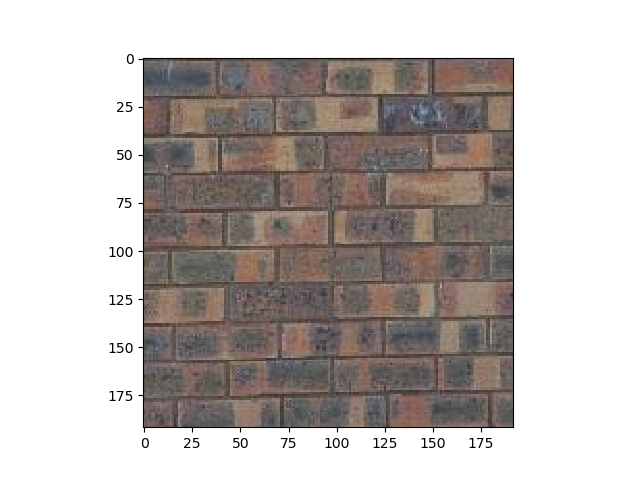

In [20]:
sample_img_dir = 'samples/bricks_small.jpg' # feel free to change
sample_img = None
if os.path.exists(sample_img_dir):
    sample_img = cv2.imread(sample_img_dir)
    sample_img = cv2.cvtColor(sample_img,cv2.COLOR_BGR2RGB)
    plt.close()
    plt.imshow(sample_img)

In [4]:
def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
    return_array = np.zeros((out_size,out_size,3), dtype=int)
    n_windows = int(out_size/patch_size)
    for i in range(n_windows):
        for j in range(n_windows):
            x = np.random.randint(0, sample.shape[1]-patch_size)
            y = np.random.randint(0, sample.shape[0]-patch_size)
            return_array[i*patch_size:i*patch_size+patch_size,j*patch_size:j*patch_size+patch_size,:] = sample[y:y+patch_size,x:x+patch_size,:]
    return return_array

<IPython.core.display.Javascript object>


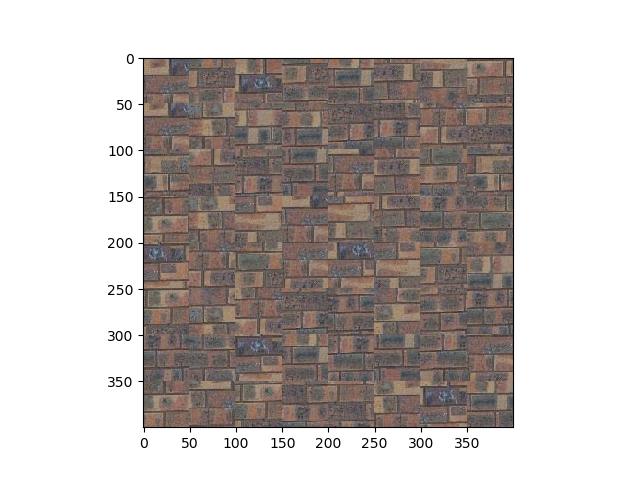

In [21]:
out_size = 400  # feel free to change to debug
patch_size = 50 # feel free to change to debug
brick_random = quilt_random(sample_img, out_size, patch_size)
if brick_random.any():
    plt.close()
    plt.imshow(brick_random)

### Part II: Overlapping Patches (30 pts)

In [6]:
def ssd_patch(mask, template, texture_img):
    out_size = texture_img.shape[0]
    patch_size = mask.shape[0]
    #offset = int(patch_size/2)
    #ssd_img = np.ones((out_size-patch_size+1,out_size-patch_size+1))
    n_windows = out_size-patch_size+1
    I = texture_img/255
    M = mask
    T = template/255
    #for r in range(n_windows):
    #    for c in range(n_windows):
    #        texture_patch = texture_img[r:r+patch_size,c:c+patch_size,:]
    #        ssd = np.sum(np.square(template - (texture_patch*mask)))
    #        ssd_img[r,c] = ssd
    

    hp = int(.5*patch_size)
    ssd_img = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
    ssd_img = ssd_img[hp:ssd_img.shape[0]-hp,hp:ssd_img.shape[1]-hp]
    ssd_img = ssd_img - np.min(ssd_img)
    ssd_img = ssd_img/np.max(ssd_img)
    return ssd_img

In [7]:
def choose_sample(ssd_img, patch_size, texture_img, k=5):
    
    ssd_rvl = ssd_img.ravel()
    mink = ssd_rvl[np.argpartition(ssd_rvl, k)[k-1]]  
    where_a = np.where(ssd_img<=mink)
    p = patch_size
    i = np.random.randint(0, where_a[0].shape[0])
    r = where_a[0][i]
    c = where_a[1][i]
    return_patch = texture_img[r:r+p,c:c+p,:]
    #print(f'return patch shape: {return_patch.shape}')
    return return_patch

In [8]:
def set_mask(r, c, patch_size, overlap):
    return_mask = np.zeros((patch_size,patch_size,3))
    v = False
    h = False
    if r > 0:
        return_mask[0:overlap,:,:] = np.ones((overlap,patch_size,3))
        h = True    #we need a horizontal cut
    if c > 0:
        return_mask[:,0:overlap,:] = np.ones((patch_size,overlap,3))
        v = True    #we need a vertical cut
    if r==0 and c==0:
        return_mask = 1 - return_mask
    return return_mask, v, h

In [9]:
def quilt_simple(sample, out_size, patch_size, overlap, k):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :return: numpy.ndarray
    """
    # Todo 
    x = np.random.randint(0, sample.shape[1]-patch_size)
    y = np.random.randint(0, sample.shape[0]-patch_size)

    n_windows = int((out_size-overlap)/(patch_size-overlap))
    return_img = np.zeros((out_size,out_size,3), dtype=int)
    
    seed_patch = sample[y:y+patch_size,x:x+patch_size,:]
    return_img[0:0+patch_size,0:0+patch_size,:] = seed_patch

    for r in range(n_windows): #n_windows
        overlap_r = r*(patch_size-overlap)
        for c in range(n_windows): #n_windows
            mask, _, _ = set_mask(r,c,patch_size,overlap)
            #mask = np.zeros((patch_size,patch_size,3))
            #mask[:,0:overlap,:] = np.ones((patch_size,overlap,3))
            
            overlap_c = c*(patch_size-overlap)
            template = return_img[overlap_r:overlap_r+patch_size,overlap_c:overlap_c+patch_size,:]
            ssd_img = ssd_patch(mask,template,sample)
            
            match_patch = choose_sample(ssd_img,patch_size,sample,k)
            #print(f'ssd shape: {ssd_img.shape} patch shape: {patch_size} match_patch shape: {match_patch.shape}')
            return_img[overlap_r:overlap_r+patch_size,overlap_c:overlap_c+patch_size,:] = match_patch
    
    return return_img

<IPython.core.display.Javascript object>


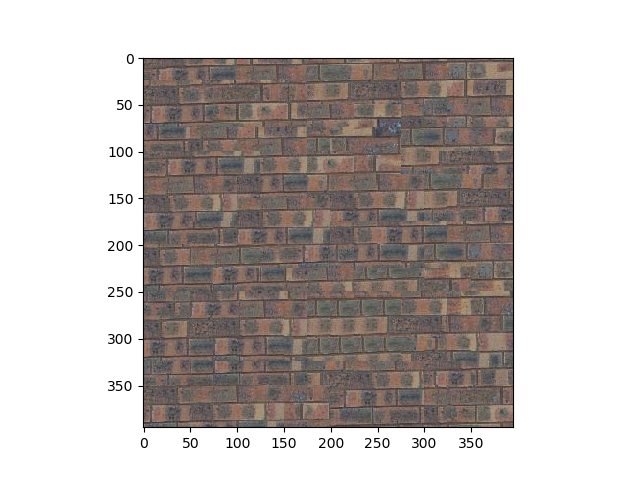

In [22]:
brick_quilt = quilt_simple(sample_img, 395, 45, 20, 5) #feel free to change parameters to get best results


if brick_quilt.any():
    plt.close()
    plt.imshow(brick_quilt)

### Part III: Seam Finding (20 pts)


In [11]:
def quilt_cut(sample, out_size, patch_size, overlap, k):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param k: int
    :return: numpy.ndarray
    """
    x = np.random.randint(0, sample.shape[1]-patch_size)
    y = np.random.randint(0, sample.shape[0]-patch_size)

    n_windows = int((out_size-overlap)/(patch_size-overlap))
    return_img = np.zeros((out_size,out_size,3), dtype=int)
    
    seed_patch = sample[y:y+patch_size,x:x+patch_size,:]
    return_img[0:0+patch_size,0:0+patch_size,:] = seed_patch

    for r in range(n_windows): #n_windows
        overlap_r = r*(patch_size-overlap)
        for c in range(n_windows): #n_windows
            mask, v, h = set_mask(r,c,patch_size,overlap)
            #mask = np.zeros((patch_size,patch_size,3))
            #mask[:,0:overlap,:] = np.ones((patch_size,overlap,3))
            
            overlap_c = c*(patch_size-overlap)
            template = return_img[overlap_r:overlap_r+patch_size,overlap_c:overlap_c+patch_size,:]
            ssd_img = ssd_patch(mask,template,sample)
            
            match_patch = choose_sample(ssd_img,patch_size,sample,k)
            mask_2d = np.ones((mask.shape[0],mask.shape[1]),dtype=int)
            
            if h:
                patch_overlap = match_patch[0:overlap,:,:]
                template_overlap = template[template.shape[0]-overlap:template.shape[0],:,:]
                bndcost = np.sum(np.square(template_overlap - patch_overlap),axis=2)
                bnd_mask = cut(bndcost)
                mask_2d[0:overlap,:] = mask_2d[0:overlap,:]& bnd_mask
                
            if v:
                patch_overlap = match_patch[:,0:overlap,:]
                template_overlap = template[:,template.shape[1]-overlap:template.shape[1],:]
                bndcost = np.sum(np.square(template_overlap - patch_overlap),axis=2)
                bnd_mask = cut(bndcost.T).T
                mask_2d[:,0:overlap] = mask_2d[:,0:overlap]& bnd_mask
            
            #print(f'ssd shape: {ssd_img.shape} patch shape: {patch_size} match_patch shape: {match_patch.shape}')
            mask = np.stack((mask_2d,mask_2d,mask_2d),axis=2)
            return_img[overlap_r:overlap_r+patch_size,overlap_c:overlap_c+patch_size,:] *= 1 - mask
            return_img[overlap_r:overlap_r+patch_size,overlap_c:overlap_c+patch_size,:] += match_patch * mask
    
    return return_img

(395, 395, 3)


<IPython.core.display.Javascript object>


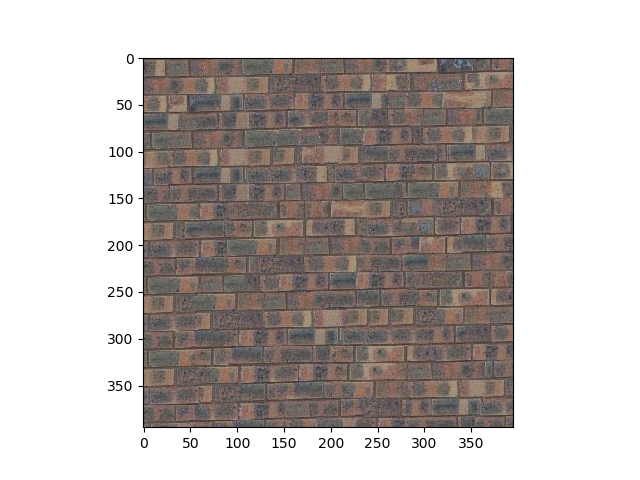

In [39]:
brick_smart_cut = quilt_cut(sample_img, 395, 45, 20, 3)
#if res.any():
print(brick_smart_cut.shape)
plt.close()
plt.imshow(brick_smart_cut)

<IPython.core.display.Javascript object>


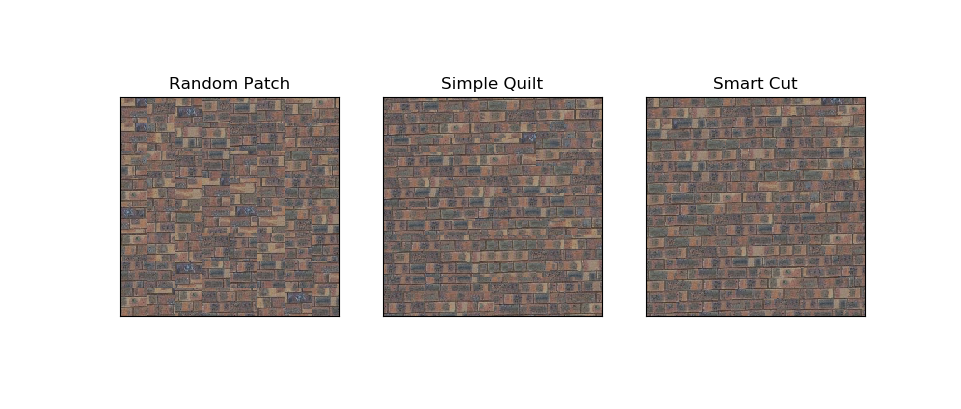

In [47]:
plt.close()
fig,a =  plt.subplots(1,3)
#plt.xticks([])
a[0].imshow(brick_random)
a[0].set_title('Random Patch')
a[0].set_xticks([])
a[0].set_yticks([])
a[1].imshow(brick_quilt)
a[1].set_title('Simple Quilt')
a[1].set_xticks([])
a[1].set_yticks([])
a[2].imshow(brick_smart_cut)
a[2].set_title('Smart Cut')
a[2].set_xticks([])
a[2].set_yticks([])

plt.show()

### part IV: Texture Transfer (30 pts)

In [13]:
def blur_img(img,kernel_size=None):
    if kernel_size is None:
        kernel_size = int(min(img.shape[0],img.shape[1])/15)
    if kernel_size % 2 == 0:
        kernel_size += 1
    blur_img = cv2.GaussianBlur(img,(kernel_size,kernel_size),cv2.BORDER_DEFAULT)

    return blur_img

In [14]:
def texture_transfer(source_texture, target_img, patch_size, overlap, k, alpha, synth_img=None):
    """
    Feel free to add function parameters
    """
    
    assert(alpha <= 1 and alpha >= 0)
    assert(patch_size % 2 == 1)
    target_img_hsv = cv2.cvtColor(target_img,cv2.COLOR_RGB2HSV)
    source_texture_hsv = cv2.cvtColor(source_texture,cv2.COLOR_RGB2HSV) 
    
    [h_ti,s_ti,v_ti] = [target_img_hsv[:,:,0],target_img_hsv[:,:,1],target_img_hsv[:,:,2]]
    [h_st,s_st,v_st] = [source_texture_hsv[:,:,0],source_texture_hsv[:,:,1],source_texture_hsv[:,:,2]]

    source_texture_coor = blur_img(v_st)
    target_img_coor = blur_img(v_ti)
    
    x = 0 #np.random.randint(0, sample.shape[1]-patch_size)
    y = 0 #np.random.randint(0, sample.shape[0]-patch_size)

    n_r_windows = int((target_img.shape[0]-overlap)/(patch_size-overlap))
    n_c_windows = int((target_img.shape[1]-overlap)/(patch_size-overlap))
    return_img = np.zeros((target_img.shape[0],target_img.shape[1],3), dtype=int)
    
    seed_target_patch = target_img_coor[y:y+patch_size,x:x+patch_size]
    ssd_transfer = ssd_patch(np.ones((patch_size,patch_size)),seed_target_patch,source_texture_coor)
    match_patch = choose_sample(ssd_transfer,patch_size,source_texture,k)
    return_img[0:0+patch_size,0:0+patch_size,:] = match_patch

    for r in range(n_r_windows): #n_windows
        overlap_r = r*(patch_size-overlap)
        for c in range(n_c_windows): #n_windows
            mask, v, h = set_mask(r,c,patch_size,overlap)
            #mask = np.zeros((patch_size,patch_size,3))
            #mask[:,0:overlap,:] = np.ones((patch_size,overlap,3))
            
            overlap_c = c*(patch_size-overlap)
            overlap_template = return_img[overlap_r:overlap_r+patch_size,overlap_c:overlap_c+patch_size,:]
            target_template = target_img_coor[overlap_r:overlap_r+patch_size,overlap_c:overlap_c+patch_size]
            
            ssd_overlap = ssd_patch(mask,overlap_template,source_texture)
            
            if synth_img is not None:
                synth_template = synth_img[overlap_r:overlap_r+patch_size,overlap_c:overlap_c+patch_size,:]
                ssd_synth = ssd_patch(mask,synth_template,source_texture)
                ssd_synth = ssd_synth - np.min(ssd_synth)
                ssd_synth = ssd_synth/np.max(ssd_synth)
                ssd_overlap += ssd_synth
                
            
            ssd_overlap = ssd_overlap - np.min(ssd_overlap)
            ssd_overlap = ssd_overlap/np.max(ssd_overlap)
            
            ssd_transfer = ssd_patch(mask[:,:,0].reshape((mask.shape[0],-1)),target_template,source_texture_coor)
            ssd_transfer = np.stack((ssd_transfer,ssd_transfer,ssd_transfer),axis=2)
            ssd_transfer = ssd_transfer - np.min(ssd_transfer)
            ssd_transfer = ssd_transfer/np.max(ssd_transfer)
            
            ssd_img = alpha * ssd_overlap + (1-alpha) * ssd_transfer
            ssd_img = ssd_img - np.min(ssd_img)
            ssd_img = ssd_img/np.max(ssd_img)
            match_patch = choose_sample(ssd_img,patch_size,source_texture,k)
            mask_2d = np.ones((mask.shape[0],mask.shape[1]),dtype=int)
            
            if h:
                patch_overlap = match_patch[0:overlap,:,:]
                template_overlap = overlap_template[overlap_template.shape[0]-overlap:overlap_template.shape[0],:,:]
                bndcost = np.sum(np.square(template_overlap - patch_overlap),axis=2)
                bnd_mask = cut(bndcost)
                mask_2d[0:overlap,:] = mask_2d[0:overlap,:]& bnd_mask
                
            if v:
                patch_overlap = match_patch[:,0:overlap,:]
                template_overlap = overlap_template[:,overlap_template.shape[1]-overlap:overlap_template.shape[1],:]
                bndcost = np.sum(np.square(template_overlap - patch_overlap),axis=2)
                bnd_mask = cut(bndcost.T).T
                mask_2d[:,0:overlap] = mask_2d[:,0:overlap]& bnd_mask
            
            #print(f'ssd shape: {ssd_img.shape} patch shape: {patch_size} match_patch shape: {match_patch.shape}')
            mask = np.stack((mask_2d,mask_2d,mask_2d),axis=2)
            return_img[overlap_r:overlap_r+patch_size,overlap_c:overlap_c+patch_size,:] *= 1 - mask
            return_img[overlap_r:overlap_r+patch_size,overlap_c:overlap_c+patch_size,:] += match_patch * mask
            

    return return_img

<IPython.core.display.Javascript object>


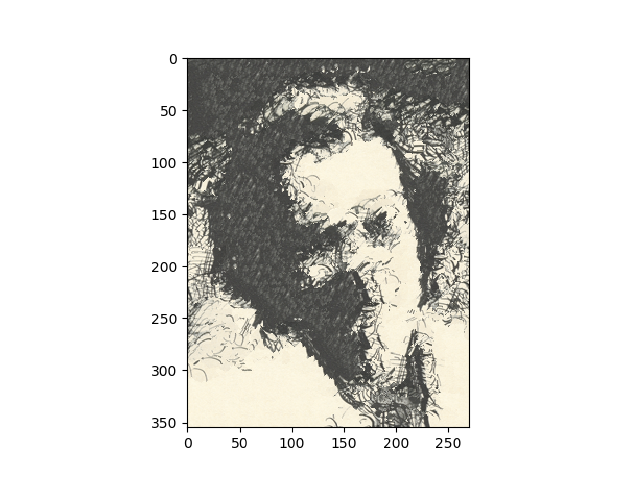

In [24]:
target_img = 'samples/feynman.tiff'
source_texture = 'samples/sketch.tiff'

target_img = cv2.imread(target_img)
source_texture = cv2.imread(source_texture)


target_img_rgb = cv2.cvtColor(target_img,cv2.COLOR_BGR2RGB)
#target_img_hsv = cv2.cvtColor(target_img_rgb,cv2.COLOR_RGB2HSV) 

source_texture_rgb = cv2.cvtColor(source_texture,cv2.COLOR_BGR2RGB)
#source_texture_hsv = cv2.cvtColor(source_texture_rgb,cv2.COLOR_RGB2HSV) 


#[h_ti,s_ti,v_ti] = [target_img_hsv[:,:,0],target_img_hsv[:,:,1],target_img_hsv[:,:,2]]
#[h_st,s_st,v_st] = [source_texture_hsv[:,:,0],source_texture_hsv[:,:,1],source_texture_hsv[:,:,2]]
#
#source_texture_coor = blur_img(v_st)
#target_img_coor = blur_img(v_ti)

transfer_img = texture_transfer(source_texture_rgb, target_img_rgb, patch_size=31, overlap=25, k=40, alpha=0.2)

plt.close()
plt.imshow(transfer_img)

In [16]:
def texture_transfer_itt(source_texture, target_img, patch_size, overlap, k=40, N=5):
    alpha=0.1
    p=patch_size
    o=overlap
    synth_img = texture_transfer(source_texture_rgb, target_img_rgb, patch_size=p, overlap=25, k=40, alpha=0.1)
    
    for i in range(1,N):
        p -= int(p/3)
        if p%2==0:    p+=1
        alpha=0.8*i/(N-1)+0.1
        o=int(p/2)
        synth_img = texture_transfer(source_texture_rgb, target_img_rgb, patch_size=p, overlap=o, k=40, alpha=alpha,synth_img=synth_img)
    return synth_img

<IPython.core.display.Javascript object>


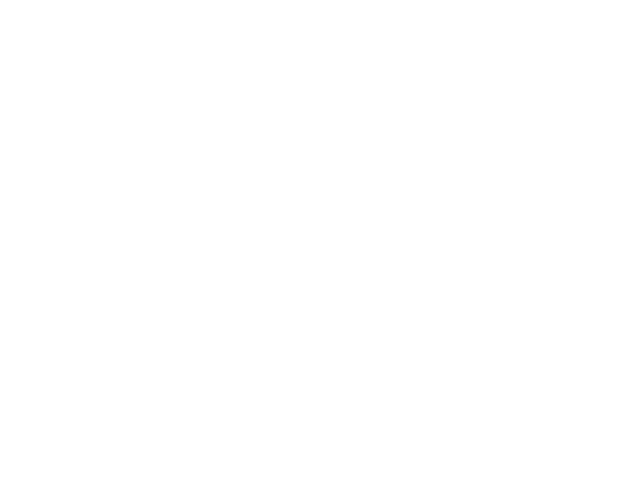

In [17]:
transfer_img = texture_transfer_itt(source_texture_rgb, target_img_rgb, patch_size=41, overlap=25, k=40,N=5)

plt.close()
plt.imshow(transfer_img)

### Draw Smart Cut

In [50]:
def random_patch(sample, patch_size):
    x = np.random.randint(0, sample.shape[1]-patch_size)
    y = np.random.randint(0, sample.shape[0]-patch_size)
    return_patch = sample[y:y+patch_size,x:x+patch_size,:]
    return return_patch

True


<IPython.core.display.Javascript object>


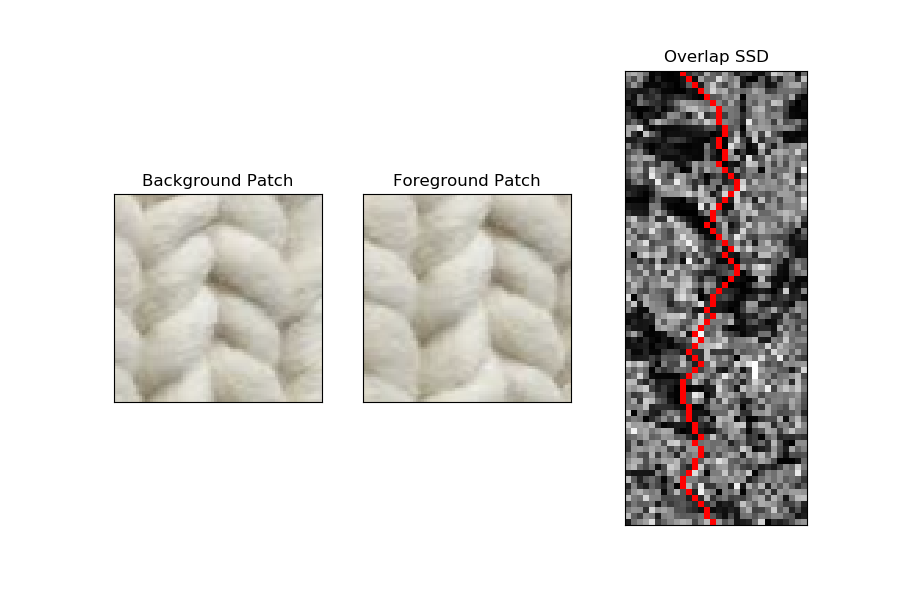

[]

In [83]:
source_texture = 'samples/texture.png'
source_texture = cv2.imread(source_texture)
source_texture_rgb = cv2.cvtColor(source_texture,cv2.COLOR_BGR2RGB)

patch_size = 75
overlap=30
patch_a = random_patch(source_texture_rgb,patch_size)
patch_b = random_patch(source_texture_rgb,patch_size)

mask, v, h = set_mask(0,1,patch_size,overlap)

patch_overlap = patch_b[:,0:overlap,:]
template_overlap = patch_a[:,patch_a.shape[1]-overlap:patch_a.shape[1],:]
bndcost = np.sum(np.square(template_overlap - patch_overlap),axis=2)
bndcost = bndcost - np.min(bndcost)
bndcost = bndcost/np.max(bndcost)

bnd_mask = cut(bndcost.T).T
bndcost = np.stack((bndcost,bndcost,bndcost),axis=2)

r=0
c=0
for r in range(bnd_mask.shape[0]):
    for c in range(bnd_mask.shape[1]-1):
        if bnd_mask[r,c+1]>0.5:
            bndcost[r,c,0]=1   
            bndcost[r,c,1]=0
            bndcost[r,c,2]=0
            break

plt.close()
#plt.imshow(bndcost)

fig,a =  plt.subplots(1,3)
#plt.xticks([])
a[0].imshow(patch_a)
a[0].set_title('Background Patch')
a[0].set_xticks([])
a[0].set_yticks([])
a[1].imshow(patch_b)
a[1].set_title('Foreground Patch')
a[1].set_xticks([])
a[1].set_yticks([])
a[2].imshow(bndcost)
a[2].set_title('Overlap SSD')
a[2].set_xticks([])
a[2].set_yticks([])


#plt.imshow(patch_b)

### Bells & Whistles

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

In [18]:
def texture_transfer_itt(source_texture, target_img, patch_size, overlap, k=40, N=5):
    alpha=0.1
    p=patch_size
    o=overlap
    synth_img = texture_transfer(source_texture_rgb, target_img_rgb, patch_size=p, overlap=25, k=40, alpha=0.1)
    
    for i in range(1,N):
        p -= int(p/3)
        if p%2==0:    p+=1
        alpha=0.8*i/(N-1)+0.1
        o=int(p/2)
        synth_img = texture_transfer(source_texture_rgb, target_img_rgb, patch_size=p, overlap=o, k=40, alpha=alpha,synth_img=synth_img)
    return synth_img

<IPython.core.display.Javascript object>


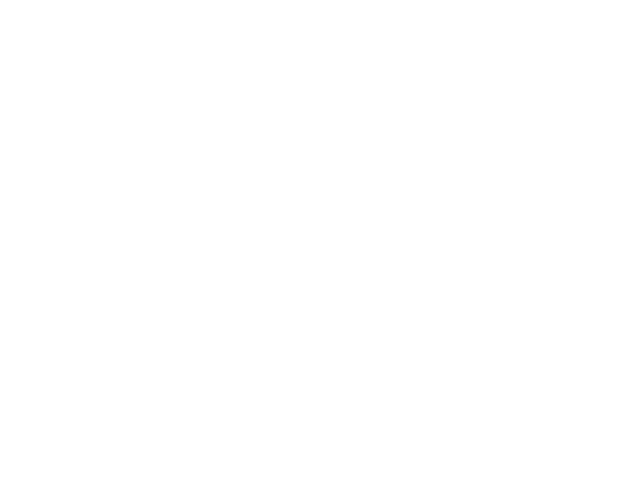

In [19]:
transfer_img = texture_transfer_itt(source_texture_rgb, target_img_rgb, patch_size=51, overlap=25, k=40,N=5)

plt.close()
plt.imshow(transfer_img)